In [1]:
!nvidia-smi

Mon Mar 25 13:16:26 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:01:00.0 Off |                  N/A |
| 23%   30C    P2    58W / 250W |      0MiB / 12195MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os import path as p
import os
from plot_history import plot_history

In [3]:
from keras.layers import Input, Activation, BatchNormalization
from keras.layers.core import Dense, Dropout
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Flatten
from keras.layers import Activation
from keras.models import Model
from keras.losses import mse
from keras.optimizers import Adadelta, Adam, SGD
# from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

Using TensorFlow backend.


In [4]:
data_dir = '/storage/yw18581/data/'
data_folder = os.path.join(data_dir, 'train_validation_test')

In [5]:
X_train = np.load(os.path.join(data_folder, 'Xy_train_dist.npz'))["y"]
y_train = np.load(os.path.join(data_folder, 'Xy_train_dist.npz'))["dist"]

In [6]:
X_val = np.load(os.path.join(data_folder,'Xy_val_dist.npz'))["y"]
y_val = np.load(os.path.join(data_folder, 'Xy_val_dist.npz'))["dist"]

In [7]:
X_test = np.load(os.path.join(data_folder, 'Xy_test_dist.npz'))["y"]
y_test = np.load(os.path.join(data_folder, 'Xy_test_dist.npz'))["dist"]

In [69]:
X_pred = np.load(os.path.join(data_dir, 'trained_models/UNet_training_generator_1500epochs/Xy_test_predicted_UNet.npz'))['y']
y_pred = np.load(os.path.join(data_dir, 'trained_models/UNet_training_generator_1500epochs/Xy_test_predicted_UNet.npz'))['dist']

In [9]:
def cut_X(arr, reshape = None):
    x_cut = arr[:,960:1300,600:]
    if reshape:
        if len(x_cut.shape)>3:
            x_cut = x_cut[...,0]
            x_cut_out = x_cut.reshape(x_cut.shape[0],x_cut.shape[1]*x_cut.shape[2])
    else:
        x_cut_out = x_cut
    return x_cut_out

In [10]:
X_train_cut = cut_X(X_train)

In [11]:
X_val_cut = cut_X(X_val)

In [12]:
X_test_cut = cut_X(X_test)

In [70]:
X_pred_cut = cut_X(X_pred)

In [14]:
N_EPOCHS = 30
BATCH_SIZE = 8

CHECKPOINT_FOLDER_PATH = p.join(data_dir, 'trained_models')
TASK_NAME = 'Leaf_position_regression'
TASK_FOLDER_PATH = p.join(CHECKPOINT_FOLDER_PATH, TASK_NAME)

if not p.exists(TASK_FOLDER_PATH):
    os.makedirs(TASK_FOLDER_PATH)

In [15]:
K.clear_session()

In [18]:
def create_model(input_shape):
    input_layer = Input(shape=input_shape,name='input')
    x = Conv2D(8,kernel_size=3, padding='same', 
               name='conv1')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=2, strides=2, padding='same', name='pool1')(x)
    
    x = Conv2D(16,kernel_size=3, padding='same', name='conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=2, strides=2, padding='same', name='pool2')(x)
    
    x = Conv2D(32,kernel_size=3, padding='same', name='conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(32,kernel_size=3, padding='same', name='conv4')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Maybe a Flatten is needed here.
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    
    prediction = Dense(1, activation='linear')(x)
    model = Model(inputs = input_layer, outputs = prediction)
    return model

model = create_model(input_shape=(X_train_cut.shape[1:]))
OPTIMIZER = 'Adadelta'
model.compile(loss='mse',
              optimizer=SGD(), metrics = ['mse'])
callbacks = [#EarlyStopping(monitor='val_loss',patience = 8, verbose = True), 
             ModelCheckpoint(os.path.join(TASK_FOLDER_PATH,
                                          "leaf_regression_cnn_{}epochs_{}batch_{}.hdf5".format(N_EPOCHS,BATCH_SIZE, OPTIMIZER)), 
                             monitor='val_loss')]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 340, 800, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 340, 800, 8)       80        
_________________________________________________________________
batch_normalization_9 (Batch (None, 340, 800, 8)       32        
_________________________________________________________________
activation_9 (Activation)    (None, 340, 800, 8)       0         
_________________________________________________________________
pool1 (AveragePooling2D)     (None, 170, 400, 8)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 170, 400, 16)      1168      
_________________________________________________________________
batch_normalization_10 (Batc (None, 170, 400, 16)      64        
__________

In [19]:
history = model.fit(X_train_cut, y_train, validation_data=(X_val_cut, y_val),
                    epochs=N_EPOCHS, verbose=True, batch_size=BATCH_SIZE, shuffle=True, 
                    callbacks = callbacks)

Train on 768 samples, validate on 192 samples
Epoch 1/30
768/768 [==============================] - 7s 9ms/step - loss: 84203994466061605928960.0000 - mean_squared_error: 84203994466061605928960.0000 - val_loss: 67789866042994458624.0000 - val_mean_squared_error: 67789866042994458624.0000
Epoch 2/30
768/768 [==============================] - 4s 5ms/step - loss: 17463285196733984768.0000 - mean_squared_error: 17463285196733984768.0000 - val_loss: 1401428999548174336.0000 - val_mean_squared_error: 1401428999548174336.0000
Epoch 3/30
768/768 [==============================] - 4s 5ms/step - loss: 361020923449092800.0000 - mean_squared_error: 361020923449092800.0000 - val_loss: 28971946529346900.0000 - val_mean_squared_error: 28971946529346900.0000
Epoch 4/30
768/768 [==============================] - 4s 5ms/step - loss: 7463438592070998.0000 - mean_squared_error: 7463438592070998.0000 - val_loss: 598941200547840.0000 - val_mean_squared_error: 598941200547840.0000
Epoch 5/30
768/768 [======

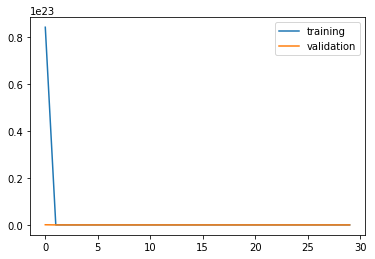

In [20]:
plot_history(history)

In [43]:
from sklearn.ensemble import RandomForestRegressor

In [44]:
X_train_cut.shape

(768, 340, 800, 1)

In [45]:
y_train.shape

(768,)

In [46]:
y_train[0:10]

array([ 2,  4,  4, 25,  4,  4, 25, 25, 25,  4])

In [47]:
X_train_RF = X_train_cut.reshape((X_train_cut.shape[0],
                                  X_train_cut.shape[1]*X_train_cut.shape[2]))

In [48]:
X_train_RF.shape

(768, 272000)

## Random Forest Regressor

In [49]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, 
                              criterion='mse'  # default
                             )

model.fit(X_train_RF, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [51]:
# Training Performance
model.score(X_train_RF, y_train)  # will calculate MSE by default

0.9999415753278601

In [85]:
rf1 = model

In [86]:
rf1.predict(X_test_cut.reshape(240,340*800))

array([25.  , 10.  ,  2.  ,  4.  ,  2.  , 24.85,  3.92, 25.  ,  4.  ,
       10.  ,  9.82,  2.  ,  2.  , 10.  ,  2.  ,  2.  ,  4.  , 10.  ,
       10.  ,  4.  ,  4.  ,  9.88, 10.  ,  4.  ,  2.  ,  2.  , 10.  ,
        4.  ,  4.  ,  4.  ,  4.  , 10.  , 10.  , 10.  ,  4.  ,  4.  ,
        3.82,  2.  ,  3.72, 10.  , 25.  ,  2.  , 24.7 ,  4.  , 24.1 ,
        3.44,  4.  ,  2.  ,  2.04,  2.  ,  9.94, 25.  ,  4.  ,  2.  ,
       25.  ,  3.98, 25.  , 25.  , 24.85,  4.  ,  4.  ,  2.  ,  2.02,
        2.  ,  2.  , 25.  ,  2.  ,  4.  ,  4.  ,  3.7 ,  4.  ,  2.  ,
       25.  ,  2.  ,  2.  ,  4.  ,  2.  ,  2.  , 24.85,  9.82, 25.  ,
        2.  ,  9.82,  2.  ,  4.  , 25.  , 25.  ,  2.  , 25.  , 10.  ,
        4.  ,  3.92,  2.  ,  3.96, 25.  , 10.  ,  4.  , 25.  ,  2.  ,
        2.  ,  4.  ,  2.26, 10.  ,  2.  ,  9.94, 10.  , 25.  , 25.  ,
       25.  , 25.  ,  4.  , 10.  ,  2.  , 25.  , 10.  , 25.  ,  2.  ,
        2.  , 10.  ,  2.  ,  3.94, 25.  , 24.1 , 25.  ,  4.  , 25.  ,
        3.94,  2.  ,

In [67]:
from sklearn.metrics import mean_squared_error

In [52]:
X_test_cut.shape

(240, 340, 800, 1)

In [56]:
preds = model.predict(X_test_cut.reshape(240, 340*800))

In [60]:
y_test

array([25, 10,  2,  4,  2, 25,  4, 25,  4, 10, 10,  2,  2, 10,  2,  2,  4,
       10, 10,  4,  4, 10, 10,  4,  2,  2, 10,  4,  4,  4,  4, 10, 10, 10,
        4,  4,  4,  2,  4, 10, 25,  2, 25,  4, 25,  4,  4,  2,  2,  2, 10,
       25,  4,  2, 25,  4, 25, 25, 25,  4,  4,  2,  2,  2,  2, 25,  2,  4,
        4,  4,  4,  2, 25,  2,  2,  4,  2,  2, 25, 10, 25,  2, 10,  2,  4,
       25, 25,  2, 25, 10,  4,  4,  2,  4, 25, 10,  4, 25,  2,  2,  4,  2,
       10,  2, 10, 10, 25, 25, 25, 25,  4, 10,  2, 25, 10, 25,  2,  2, 10,
        2,  4, 25, 25, 25,  4, 25,  4,  2, 10, 10,  2, 25,  4,  2, 25, 10,
       10,  4,  4, 25, 25, 10,  4, 10, 10,  4, 10, 10,  4,  4, 25,  4, 10,
        2, 25,  4,  4,  2, 25,  4, 25, 25, 25,  2,  2, 10,  2, 10, 10,  2,
       10, 25,  4,  2,  2,  4,  2, 25,  2, 10, 10, 10,  2, 25,  2, 25,  4,
       10,  4,  4, 10, 10,  2, 10,  4,  2,  2, 25, 25,  2, 10, 25, 10, 25,
       10,  2, 10, 10, 10, 25, 25, 10,  4, 10, 25,  2, 10,  2, 10,  4, 25,
       25, 25, 25,  2,  4

In [61]:
preds

array([25.  , 10.  ,  2.  ,  4.  ,  2.  , 24.85,  3.92, 25.  ,  4.  ,
       10.  ,  9.82,  2.  ,  2.  , 10.  ,  2.  ,  2.  ,  4.  , 10.  ,
       10.  ,  4.  ,  4.  ,  9.88, 10.  ,  4.  ,  2.  ,  2.  , 10.  ,
        4.  ,  4.  ,  4.  ,  4.  , 10.  , 10.  , 10.  ,  4.  ,  4.  ,
        3.82,  2.  ,  3.72, 10.  , 25.  ,  2.  , 24.7 ,  4.  , 24.1 ,
        3.44,  4.  ,  2.  ,  2.04,  2.  ,  9.94, 25.  ,  4.  ,  2.  ,
       25.  ,  3.98, 25.  , 25.  , 24.85,  4.  ,  4.  ,  2.  ,  2.02,
        2.  ,  2.  , 25.  ,  2.  ,  4.  ,  4.  ,  3.7 ,  4.  ,  2.  ,
       25.  ,  2.  ,  2.  ,  4.  ,  2.  ,  2.  , 24.85,  9.82, 25.  ,
        2.  ,  9.82,  2.  ,  4.  , 25.  , 25.  ,  2.  , 25.  , 10.  ,
        4.  ,  3.92,  2.  ,  3.96, 25.  , 10.  ,  4.  , 25.  ,  2.  ,
        2.  ,  4.  ,  2.26, 10.  ,  2.  ,  9.94, 10.  , 25.  , 25.  ,
       25.  , 25.  ,  4.  , 10.  ,  2.  , 25.  , 10.  , 25.  ,  2.  ,
        2.  , 10.  ,  2.  ,  3.94, 25.  , 24.1 , 25.  ,  4.  , 25.  ,
        3.94,  2.  ,

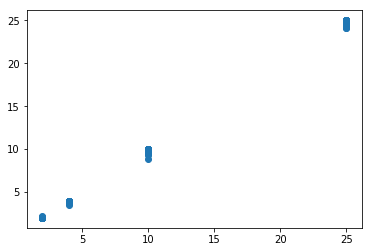

In [64]:
plt.scatter(y_test, preds)

In [68]:
mean_squared_error(y_test, preds)

0.02508041666666664

In [83]:
from sklearn.externals import joblib

In [87]:
filename = os.path.join(TASK_FOLDER_PATH,'leaf_regression_RF1.pkl')
_ = joblib.dump(rf1, filename, compress=9)

In [71]:
X_pred_cut.shape

(240, 340, 800)

In [88]:
X_predcnn_RF = X_pred_cut.reshape((X_pred_cut.shape[0],
                                  X_pred_cut.shape[1]*X_pred_cut.shape[2]))

In [91]:
model = RandomForestRegressor(max_depth=10, random_state=42,
                             n_estimators=4, n_jobs=-1, 
                              criterion='mse'  # default
                             )
rf2 = model.fit(X_predcnn_RF, y_pred)

In [92]:
model.score(X_predcnn_RF, y_pred)

1.0

In [93]:
preds_cnn = rf2.predict(X_pred_cut.reshape(240, 340*800))

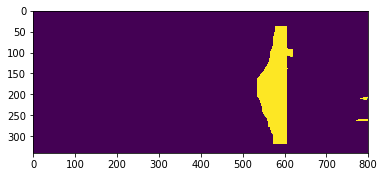

In [78]:
plt.imshow(X_pred_cut[2])

In [66]:
mse?

Signature: mse(y_true, y_pred)
Docstring: <no docstring>
File:      ~/.conda/envs/fluffy-bunnies/lib/python3.6/site-packages/keras/losses.py
Type:      function


model.save(os.path.join(data_dir,'trained_models','leaf_regression_shallow.hdf5'))

preds = model.predict(X_test_cut)

preds.ravel().shape

y_test.shape

from sklearn.metrics import mean_squared_error as mse

mse(y_test, preds.ravel())

np.unique(y_test)

t_test_2 = y_test[y_test==2]
t_test_4 = y_test[y_test==4]
t_test_10 = y_test[y_test==10]
t_test_25 = y_test[y_test==25]

print(t_test_2.shape, t_test_4.shape, t_test_10.shape, t_test_25.shape)

preds = preds.ravel()

preds

p2 = preds[y_test==2]
p4 = preds[y_test==4]
p10 = preds[y_test==10]
p25 = preds[y_test==25]

mse(t_test_2, p2)

mse(t_test_4, p4)

mse(t_test_10, p10)

mse(t_test_25, p25)

from matplotlib.image import imread

w = os.walk(os.path.join(data_dir, "10x10_15mm_v2_8bit_test"))
folder, _, files = next(w)

folder

files

gt_15 = [os.path.join(folder, f) for f in files]

gt_15

X_15 = [imread(fp)[ROW_SLICE,COL_SLICE] for fp in gt_15]

IMG_WIDTH = 1400
IMG_HEIGHT = 1400
ROW_SLICE = slice(0, 1400)
COL_SLICE = slice(1000, None)


X_15_cut = cut_X(np.asarray(X_15))

preds15 = model.predict(X_15_cut)

preds15